# 6. Unsupervised Learning

In [5]:
%matplotlib inline

**Clustering** (and outlier detection) and dimension reduction. Focus on former in this unit.

Points are represented in high-dim Euclidean spaces or any metric spaces.

### Distance functions
 * $d : D \times D \rightarrow [0, \infty)$
 * $d(x, y) \ge 0, \> \forall x, y \in D$
 * $d(x, x) = 0, \> \forall x \in D$
 * $d(x, y) = d(y, x), \> \forall x, y \in D$
 * $d(x, y) + d(y, z) \ge d(x, z), \> \forall x, y, z \in D$ (Triangle inequality)
 * **Bonus** if $d(x, y) = 0 \implies x = y, \> \forall x, y \in D$, then we say that $D$ is a **metric space**.
 
Note: it seems certain authors simply ignore distance functions without the identity of indiscernables and also call metrics distance functions (e.g. in ML slides).

## Types of clustering

### Hierarchical clustering
Build a tree representing distances among the data points.

Each point starts by being its own cluster, and then cluster keep getting combined based on their "closeness", until a certain threshold is reached (e.g. desired cluster count or compactness). Alternatively, one can keep going until only a single "cluster" exists, and return a hierarchy of clusters.

Other merging criteria:

 - minimum distance between clusters, where that distance is minimum distance between any points of each cluster
 - cluster radius (merge clusters resulting in the smallest-radius cluster) or diameter.

Other stopping criteria:

 - a new best cluster's diameter exceeds some threshold
 - a new best cluster's density exceeds some threshold (density = e.g. nr points / volume)
 - a new best cluster is considered bad (sudden jump in average diameter, compared to previous steps)
 
Picking a clustroid in non-Euclidean spaces: a point which minimizes:
 
 - $\sum$ of distances to other points in cluster
 - max distance to another point in cluster
 - $\sum$ of square distances
 
Overall, not that many things change in non-Euclidean spaces.

*Examples:* single-, average-linkage **agglomerative clustering**.



### Partitional approaches
Define and optimize an objective function defined over partitions.
TODO: What are partitions? Nothing in textbook

*Examples:* spectral clustering, graph-cut based approaches.

### Model-based approaches (main focus)
Maintain cluster "models" and infer cluster membership. Point assignment techniques. Viewed as the "standard" clustering methods.

*Examples:* k-means, Gaussian mixture models (GMMs), etc.

## Other categorization

### Euclidean space assumption
Some algorithms only work in Euclidean spaces, whereas others work with any distance measure.

Key difference: Euclidean spaces allow expressing clusters as **centroids** (average of points). This is not possible in non-Euclidean spaces; instead, we use **clustroids**, which are actual points from the dataset (which we consider representative).

### Scale assumption
Whether the algorithm assumes the data fits in main or just secondary memory. If the latter is true, we need to take certain shortcuts and summarize our clusters in memory.

## The curse of dimensionality
In high dimensional spaces (especially but not necessarily Euclidean spaces) almost all pairs of points are equally far away from each other and almost any two vectors are orthogonal (the cosine of their angle is almost always zero, since the $\cos$ denominator grows linearly in $d$, but the numerator doesn't).

This is problematic for clustering, as it becomes very hard to build clusters when there are essentially no pairs of points which are close.

### Example: Volume of a high-dimensional sphere

Consider a sphere of radius $r = 1$ in $D$-dimensional space. $V_{D}(r) = K_{D}r^{D}$, with $K_D$ being some constant (e.g. $\frac{4}{3}\pi$ in $\mathbb{R}^{2}$).

What is the volume of the sphere that lies between radius $r = 1 - \epsilon$ and $r = 1$? (i.e. its outer shell).

\begin{equation}
\begin{aligned}
    \frac{V_D(1) - V_D(1 - \epsilon)}{V_D{1}} & = \frac{K_D - K_D(1 - \epsilon)^{D}}{K_D} \\
    & = 1 - (1 - \epsilon)^{D} \xrightarrow {D\to\infty} 1
\end{aligned}
\end{equation}

 > "Thus, in spaces of high dimensionality, most of the volume of a sphere is concentrated in a thin shell near the surface!" 
 >
 > -- Bishop, PRML

The following example is based on the second data mining homework, and implements a simple form of cosine hashing, where a 1-bit hash function consists of the sign of a dot product between a to-be-hashed vector and the randomly vector which characterizes the hash function.

It can be seen that as the number of dimensions increases, the utility of the hash functions drops, as most vector pairs become orthogonal (normalized "angle" 0.5).

In [14]:
import random
import math

import numpy as np
import matplotlib.pyplot as plt


def rand_vector_uniform(dimension):
    v = [random.uniform(-1, 1) for _ in range(dimension)]
    return normalize(v)


def norm(v):
    return math.sqrt(sum([x * x for x in v]))


def normalize(v):
    nrm = norm(v)
    return [x / nrm for x in v]


def angle(v1, v2):
    assert len(v1) == len(v2)
    return math.acos(dot_product(v1, v2) / (norm(v1) * norm(v2)))


def random_hash_function(dimension):
    h = rand_vector_uniform(dimension)
    def hash_function(vector):
        return math.copysign(1.0, np.inner(vector, h))
    return hash_function


def hash_agree(v1, v2, hashes):
    return len([h for h in hashes if h(v1) == h(v2)])


def p_same_hash(N, M, d):
    """N vector pairs, M hash functions, d dimensions."""
    vecgen = rand_vector_uniform
    vector_pairs = [(vecgen(d), vecgen(d)) for _ in range(N)]
    hashes = [random_hash_function(d) for _ in range(M)]

    angle_coefs = [1 - angle(v1, v2) / math.pi for (v1, v2) in vector_pairs]
    probabilities = [hash_agree(v1, v2, hashes) * 1.0 / M for (v1, v2) in vector_pairs]
    y = angle_coefs
    x = probabilities

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(x, y, label="foo")
    ax.set_xlabel("Normalized angle (1 - angle(u, v) / pi)")
    ax.set_ylabel("Probability of u, v hashing to the same bucket")
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
    fig.text(0.5, 0.85, "Dimensions: %d, N = %d, M = %d" % (d, N, M), ha='center')
    # fig.savefig("plot-%d-%d-%d.png" % (N, M, d))
    plt.show()

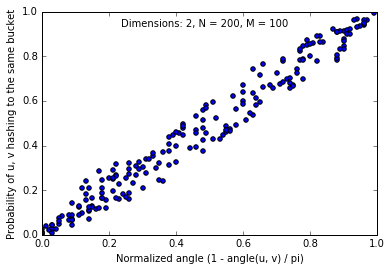

In [15]:
p_same_hash(200, 100, 2)

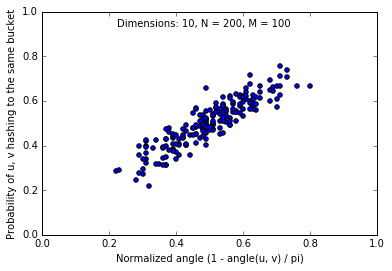

In [16]:
p_same_hash(200, 100, 10)

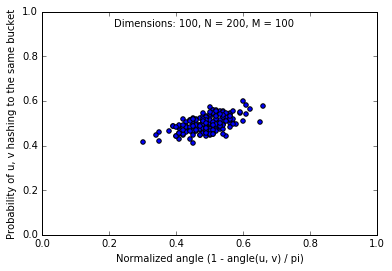

In [22]:
p_same_hash(200, 100, 100)

## The k-means problem
 * Points in Euclidean space, $x_i \in \mathbb{R}^d$.
 * Clusters as centers $\mu_j \in \mathbb{R}^d$.
 * Each point assigned to closest center.
 * **Goal**: pick centers to minimize average squared distance:
 
\begin{equation}
\begin{aligned}
L(\mu) & = L(\mu_1, \dots, \mu_k) = \sum_{i = 1}^{N} \min_{j} \| x_i - \mu_j \|_2^2 \\
\mu^{*} & = \arg \min_{\mu} L(\mu)
\end{aligned}
\end{equation}

NP-hard to solve, so we use **Lloyd's heuristic**, commonly (though not entirely accurately) referred to as the k-means algorithm. Even this heuristic can take exponential time in $\mathbb{R}^{2}$ with specially crafted input!

The feasible space for k-means is always $\mathbb{R}^{d \> \times \> k}$ (no projection).

### The algorithm:

* Initialize cluster centers (randomly or in a smarter way): $\mu^{(0)} = [\mu_1^{(0)}, \dots, \mu_k^{(0)} ]$
* Assign every point to closest cluster: $z_i = \arg \min_{j} \| x_i - \mu_j^{t - 1} \|_2^2$
* Update cluster centers to be at the center of the newly updated cluster: $\mu_j^{(t)} = \frac{1}{n_j} \sum_{i:z_i = j} x_i$
* Repeat until convergence (e.g. minimum cluster center movement threshold).

### Properties
 * Guaranteed (can be shown) to *monotonically decrease average squared distance* in each iteration: $L(\mu^{t+1}) \le L(\mu^{t})$
 * Converges to *local* optimum; in practice, we do multiple restarts so that we minimize the chance to get stuck in a local optimum.
 * $O(nkd)$ per iteration ($n$ elements, $k$ clusters, $d$ dimensions); have to process entire data set in every iteration, so difficult to parallelize.

## Scaling up k-means
TODO